# DNN-inference on Brain Tumor Dataset

By using Dnn inference method, we will study if there exist any connection between specific region of brain and brain tumor.

In [12]:
# Import relative package

import numpy as np 
import pandas as pd 
import os
from os import listdir
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import imutils    

from tensorflow import keras
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle #shuffling the data improves the model

In [3]:
IMG_PATH = []

IMG_PATH = 'brain_tumor_dataset/'
augmented_data_path = 'augmented_images/'



## Data augmentation(Not run in this version)

The selected images must be well registered. Thus this augmentation part is currently not run in the notebook

In [3]:
def augment_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=False, 
                                  vertical_flip=False, 
                                  fill_mode='nearest'
                                 )

    for filename in listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        # reshape the image
        image = image.reshape((1,)+image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,save_prefix=save_prefix, save_format='jpg'):
                i += 1
                if i > n_generated_samples:
                    break

In [7]:
augment_data(file_dir=IMG_PATH + 'yes',n_generated_samples=0, save_to_dir=augmented_data_path+'yes')

augment_data(file_dir=IMG_PATH + 'no',n_generated_samples=0, save_to_dir=augmented_data_path+'no')

In [10]:
augmented_data_path

'augmented_images/'

## Data Preprocessing

In [4]:
def crop_brain_contour(image, plot=False):
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    # extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image

def load_data(dir_list, image_size):

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            image = cv2.imread(directory+'/'+filename)
            image = crop_brain_contour(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    #X, y = shuffle(X, y)
    # convert class vectors to binary class matrices
    #y = keras.utils.to_categorical(y, 2)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')

    return X, y

In [18]:
Image_yes = IMG_PATH+'yes'
Image_no = IMG_PATH+'no'

IMG_WIDTH, IMG_HEIGHT = (112, 112)

X, y = load_data([Image_yes, Image_no], (IMG_WIDTH, IMG_HEIGHT))
y_cat = keras.utils.to_categorical(y, 2)

Number of examples is: 253
X shape is: (253, 112, 112, 3)
y shape is: (253, 1)


### Visualize Images

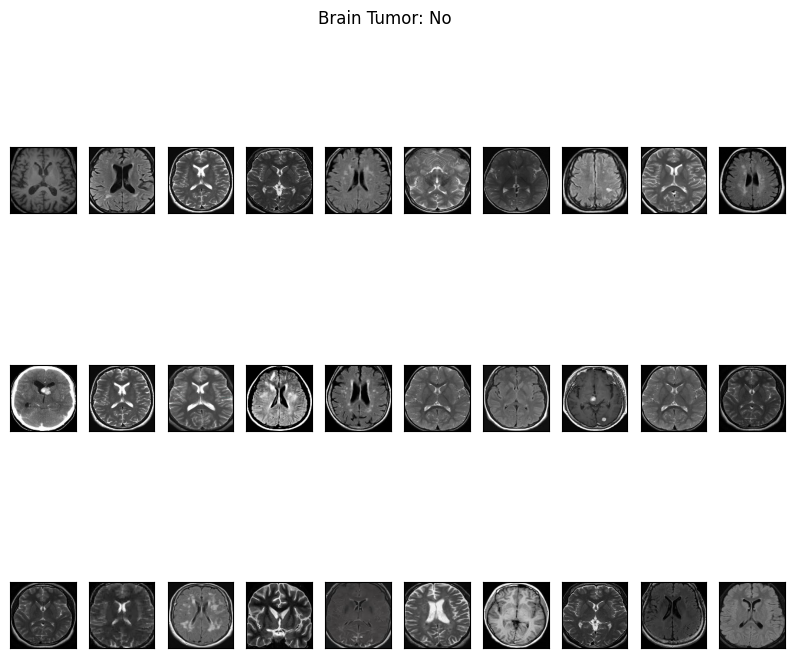

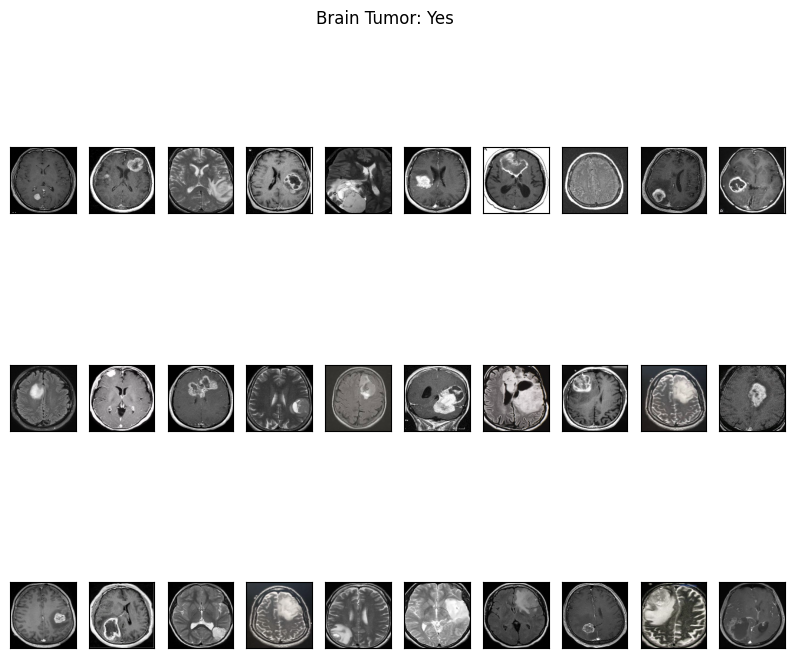

In [36]:
def plot_sample_images(X, y, n=30):
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(10, 8))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

plot_sample_images(X, y)

In [5]:
def split_data(X, y_cat, test_size=0.2):
       
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.2)

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))

number of training examples = 202
number of validation examples = 26
number of test examples = 25


## DNN inference

In [6]:
def cnn_model():

    model = Sequential()

    model.add(Conv2D(32, kernel_size=(5, 5), input_shape=(112, 112, 3), padding = 'Same'))
    model.add(Conv2D(32, kernel_size=(5, 5),  activation ='relu', padding = 'Same'))


    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size = (5,5), activation ='relu', padding = 'Same'))
    model.add(Conv2D(64, kernel_size = (5,5), activation ='relu', padding = 'Same'))

    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    model.compile(loss = "categorical_crossentropy", optimizer='Adamax')
    return model

model_null, model_alter = cnn_model(), cnn_model()

2023-10-18 17:13:17.236158: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-18 17:13:17.267630: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hanyu/anaconda3/envs/machinelearning/lib/python3.9/site-packages/cv2/../../lib64:
2023-10-18 17:13:17.267644: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-10-18 17:13:17.267844: I tensorflow/core/platform/cpu

In [10]:
## Inference based on dnn_inference
from dnn_inference.sig_test import split_test
## testing based on learning models

from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min',verbose=0, patience=20, restore_best_weights=True)


fit_params = {'callbacks': [es],
            'epochs': 30,
            'batch_size': 32,
            'validation_split': .2,
            'verbose': 0}

## testing params
test_params = { 'split': "one-split",
                'inf_ratio': None,
                'perturb': None,
                'cv_num': 2,
                'cp': 'hommel',
                'verbose': 2}

## tuning params
tune_params = { 'num_perm': 100,
                'ratio_grid': [.2, .4, .6, .8],
                'if_reverse': 0,
                'pertube': None,
                'perturb_range': 2.**np.arange(-3,3,.1),
                'tune_ratio_method': 'fuse',
                'tune_pb_method': 'fuse',
                'cv_num': 2,
                'cp': 'hommel',
                'verbose': 2}

In [13]:
from dnn_inference.sig_test import split_test
## testing based on learning models
inf_feats = [[np.arange(0,56),np.arange(0,112)],[np.arange(57,112),np.arange(0,112)]]
cue = split_test(inf_feats=inf_feats, model_null = model_null, model_alter=model_alter, eva_metric='zero-one')
P_value = cue.testing(X, y_cat, fit_params, test_params, tune_params)

INFO:tensorflow:Assets written to: ./saved/split_test/10-18_17-42/model_null_init/assets


INFO:tensorflow:Assets written to: ./saved/split_test/10-18_17-42/model_null_init/assets


INFO:tensorflow:Assets written to: ./saved/split_test/10-18_17-42/model_alter_init/assets


INFO:tensorflow:Assets written to: ./saved/split_test/10-18_17-42/model_alter_init/assets


==================== one-split test for 0-th Hypothesis ====================
(tuneHP: ratio) Est. Type 1 error: 0.080; inf sample ratio: 0.200
(tuneHP: ratio) Est. Type 1 error: 0.000; inf sample ratio: 0.400
✅ (tuneHP: ratio) Done with inf sample ratio: 0.400
(tuneHP: pb) Est. Type 1 error: 0.000; perturbation level: 0.125
✅ (tuneHP: pb) Done with inf pb level: 0.125
cv: 0; p_value: 0.66564; loss_null: 0.41584(0.49287); loss_alter: 0.38614(0.48686)
cv: 1; p_value: 0.42444; loss_null: 0.37624(0.48444); loss_alter: 0.37624(0.48444)
 🧪 0-th Hypothesis: accept H0 with p_value: 0.998
==================== one-split test for 1-th Hypothesis ====================
(tuneHP: ratio) Est. Type 1 error: 0.000; inf sample ratio: 0.200
✅ (tuneHP: ratio) Done with inf sample ratio: 0.200
(tuneHP: pb) Est. Type 1 error: 0.070; perturbation level: 0.125
(tuneHP: pb) Est. Type 1 error: 0.060; perturbation level: 0.134
(tuneHP: pb) Est. Type 1 error: 0.060; perturbation level: 0.144
(tuneHP: pb) Est. Type 

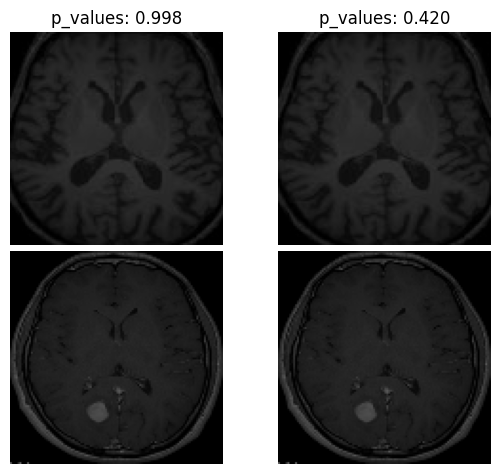

P-value: [0.9984630848807217, 0.4195206948048139]


In [14]:
cue.visual(X,y_cat,
           plt_params = {'cmap':'gray','alpha':1.})
print('P-value: %s'%P_value)

In [9]:
from dnn_inference.sig_test import split_test
## testing based on learning models
inf_feats = [[np.arange(0,224),np.arange(0,112)],[np.arange(0,224),np.arange(113,224)]]
cue = split_test(inf_feats=inf_feats, model_null = model_null, model_alter=model_alter, eva_metric='zero-one')
P_value = cue.testing(X, y, fit_params, test_params, tune_params)

INFO:tensorflow:Assets written to: ./saved/split_test/10-11_13-09/model_null_init/assets


INFO:tensorflow:Assets written to: ./saved/split_test/10-11_13-09/model_null_init/assets


INFO:tensorflow:Assets written to: ./saved/split_test/10-11_13-09/model_alter_init/assets


INFO:tensorflow:Assets written to: ./saved/split_test/10-11_13-09/model_alter_init/assets


==================== one-split test for 0-th Hypothesis ====================
(tuneHP: ratio) Est. Type 1 error: 0.000; inf sample ratio: 0.200
✅ (tuneHP: ratio) Done with inf sample ratio: 0.200
(tuneHP: pb) Est. Type 1 error: 0.000; perturbation level: 0.125
✅ (tuneHP: pb) Done with inf pb level: 0.125
cv: 0; p_value: 0.56759; loss_null: 0.28000(0.44900); loss_alter: 0.28000(0.44900)
cv: 1; p_value: 0.17003; loss_null: 0.32000(0.46648); loss_alter: 0.40000(0.48990)
 🧪 0-th Hypothesis: accept H0 with p_value: 0.510
==================== one-split test for 1-th Hypothesis ====================
(tuneHP: ratio) Est. Type 1 error: 0.040; inf sample ratio: 0.200
✅ (tuneHP: ratio) Done with inf sample ratio: 0.200
(tuneHP: pb) Est. Type 1 error: 0.000; perturbation level: 0.125
✅ (tuneHP: pb) Done with inf pb level: 0.125
cv: 0; p_value: 0.81690; loss_null: 0.32000(0.46648); loss_alter: 0.26000(0.43863)
cv: 1; p_value: 0.17182; loss_null: 0.34000(0.47371); loss_alter: 0.42000(0.49356)
 🧪 1-th 

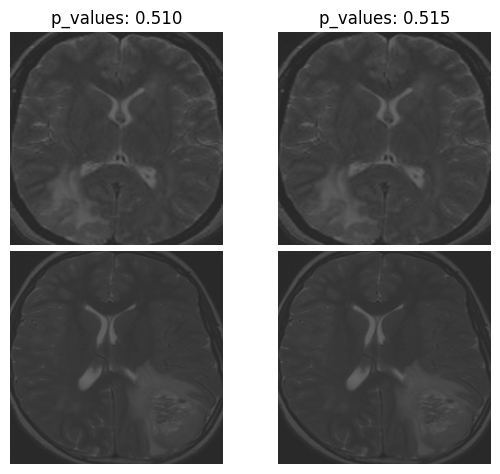

P-value: [0.5100958422504966, 0.5154506774444108]


In [10]:
cue.visual(X,y)
print('P-value: %s'%P_value)

In [8]:
from dnn_inference.sig_test import split_test
## testing based on learning models
inf_feats = [[np.arange(56,168),np.arange(0,224)],[np.arange(0,224),np.arange(56,168)]]
cue = split_test(inf_feats=inf_feats, model_null = model_null, model_alter=model_alter, eva_metric='zero-one')
P_value = cue.testing(X, y, fit_params, test_params, tune_params)

INFO:tensorflow:Assets written to: ./saved/split_test/10-11_19-32/model_null_init/assets


INFO:tensorflow:Assets written to: ./saved/split_test/10-11_19-32/model_null_init/assets


INFO:tensorflow:Assets written to: ./saved/split_test/10-11_19-32/model_alter_init/assets


INFO:tensorflow:Assets written to: ./saved/split_test/10-11_19-32/model_alter_init/assets


==================== one-split test for 0-th Hypothesis ====================
(tuneHP: ratio) Est. Type 1 error: 0.120; inf sample ratio: 0.200
(tuneHP: ratio) Est. Type 1 error: 0.000; inf sample ratio: 0.400
✅ (tuneHP: ratio) Done with inf sample ratio: 0.400
(tuneHP: pb) Est. Type 1 error: 0.000; perturbation level: 0.125
✅ (tuneHP: pb) Done with inf pb level: 0.125
cv: 0; p_value: 0.01808; loss_null: 0.34653(0.47587); loss_alter: 0.45545(0.49801)
cv: 1; p_value: 0.26350; loss_null: 0.43564(0.49584); loss_alter: 0.47525(0.49939)
 🧪 0-th Hypothesis: accept H0 with p_value: 0.054
==================== one-split test for 1-th Hypothesis ====================
(tuneHP: ratio) Est. Type 1 error: 0.140; inf sample ratio: 0.200
(tuneHP: ratio) Est. Type 1 error: 0.040; inf sample ratio: 0.400
✅ (tuneHP: ratio) Done with inf sample ratio: 0.400
(tuneHP: pb) Est. Type 1 error: 0.150; perturbation level: 0.125
(tuneHP: pb) Est. Type 1 error: 0.160; perturbation level: 0.134
(tuneHP: pb) Est. Type

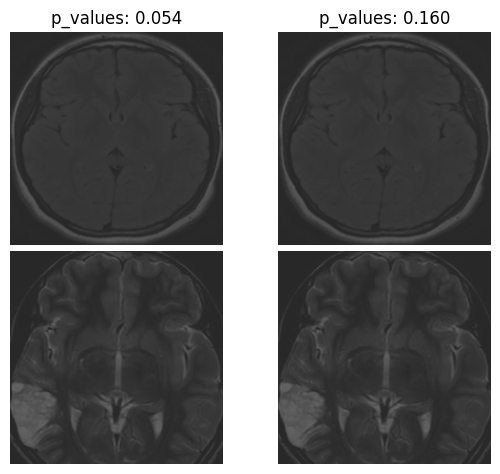

P-value: [0.054242591944450885, 0.15990681484772873]


In [9]:
cue.visual(X,y)
print('P-value: %s'%P_value)

## Save Variable

In [17]:
import pickle
def save_variable(variable,filename):
    f=open(filename,'wb')
    pickle.dump(variable,f)
    f.close()
    
 
def load_variavle(filename):
   f=open(filename,'rb')
   r=pickle.load(f)
   f.close()
   return r
save_variable(P_value,'results_pvalue_1.txt')
save_variable(cue,'results_cue_1.txt')

#ppp = load_variavle('results.txt')

INFO:tensorflow:Assets written to: ram://d1a23c39-46d0-4498-9b81-c77fea0a2437/assets


INFO:tensorflow:Assets written to: ram://d1a23c39-46d0-4498-9b81-c77fea0a2437/assets


INFO:tensorflow:Assets written to: ram://14bdb9d9-5699-4f1a-92d6-63c198918880/assets


INFO:tensorflow:Assets written to: ram://14bdb9d9-5699-4f1a-92d6-63c198918880/assets
